In [1]:
#!pip install chemprop
#!pip install rdkit-pypi
#!pip install git+https://github.com/bp-kelley/descriptastorus

import chemprop
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA

In [7]:
def evaluate_regression(true: np.ndarray, preds: np.ndarray) -> dict[str, float]:
    """Evaluates regression predictions.

    :param true: A 1D array of true values (num_molecules,).
    :param preds: A 1D array of predicted values (num_molecules,).
    :return: A dictionary of scores.
    """
    return {
        "mae": mean_absolute_error(true, preds),
        "r2": r2_score(true, preds),
    }

In [5]:
def plot_parity(y_true, y_pred, feature, y_pred_unc=None):
    axmin = min(min(y_true), min(y_pred)) - 0.1 * (max(y_true) - min(y_true))
    axmax = max(max(y_true), max(y_pred)) + 0.1 * (max(y_true) - min(y_true))

    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    metrics_regression = evaluate_regression(y_true, y_pred)

    plt.plot([axmin, axmax], [axmin, axmax], "--k")

    plt.errorbar(
        y_true,
        y_pred,
        yerr=y_pred_unc,
        linewidth=0,
        marker="o",
        markeredgecolor="w",
        alpha=1,
        elinewidth=1,
    )

    plt.xlim((axmin, axmax))
    plt.ylim((axmin, axmax))

    ax = plt.gca()
    ax.set_aspect("equal")

    at = AnchoredText(
        f"MAE = {mae:.2f}\nRMSE = {rmse:.2f}\nR2 = {metrics_regression['r2']:.2f}",
        prop=dict(size=10),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)

    ax.set(title=feature)

    plt.xlabel("True")
    plt.ylabel("Chemprop Predicted")

    plt.show()

    return

# Training

In [ ]:
arguments = [
    "--data_path", "data/filtered_chemprop_flourescence_data.csv",
    "--dataset_type", "regression",
    "--save_dir", "models/test_checkpoints-reg",
    "--epochs", "30",
    "--features_path", "data/filtered/chemprop_solvent_features.csv",
    #    "--features_generator", "rdkit_2d_normalized",
    #    "--no_features_scaling",
    "--save_smiles_splits",
]

args = chemprop.args.TrainArgs().parse_args(arguments)
mean_score, std_score = chemprop.train.cross_validate(
    args=args, train_func=chemprop.train.run_training
)

## Testing

In [ ]:
arguments = [
    "--test_path", "models/test_checkpoints-reg/fold_0/test_smiles.csv",
    "--preds_path", "models/test_preds_reg.csv",
    "--features_path", "models/test_checkpoints-reg/fold_0/test_features.csv"
    #    "--features_generator", "rdkit_2d_normalized",
    #    "--no_features_scaling",
]

args = chemprop.args.PredictArgs().parse_args(arguments)
preds = chemprop.train.make_predictions(args=args)

In [ ]:
df_test = pd.read_csv("models/test_checkpoints-reg/fold_0/test_full.csv")
df_test["absorption_preds"] = [x[0] for x in preds]
df_test["emission_preds"] = [x[1] for x in preds]
df_test["plqy_preds"] = [x[2] for x in preds]
df_test

,SMILES,Absorption/nm,Emission/nm,PLQY,absorption_preds,emission_preds,plqy_preds
0,OC(=O)CCCCCN1C2=C(C=C(S([O-])(=O)=O)C=C2)C(C)(...,710.0,732.0,NaN,476.112346,573.174804,0.514553
1,COC(C=C1)=CC=C1C(C2=NSN=C32)=CC=C3C4=NC5=C(N4C...,419.0,549.0,0.79,414.152128,540.614483,0.813902
2,CC1(C)C2=CC(N(C)C)=CC=C2C(C3=CC=CC=C3C([O-])=O...,612.0,642.0,0.75,566.107818,604.172861,0.495342
3,CC1(C)C2=C(C=CC(C=O)=C2)C3=CC=C(N4CCN(C(OC(C)(...,365.0,449.0,0.65,367.340733,457.773581,0.654192
4,OC(C=CC1=C2C=CC=C1)=C2C3=NN(C4=CC=CC=C4)N=C3C5...,292.0,380.0,0.06,328.131881,448.441933,0.368870
...,...,...,...,...,...,...,...
434,OC1=COC2=CC(C3=CC=C(N(C)C)C=C3)=CC=C2C1=O,357.0,393.0,0.26,349.904786,404.848657,0.341423
435,O=C(C1=CC=C(C2=CC(C=CC=C3)=C3S2)C4=CC=C5C(C6=C...,350.0,441.0,0.27,350.420754,414.751675,0.246933
436,F[B-]1(F)[N+]=2C(=Cc3n1c(cc3C)\C=C\c1cc(ccc1)C...,553.0,568.0,NaN,500.787398,560.898074,0.494528
437,CC1(C)C2=C(C=CC(C=O)=C2)C3=CC=C(N4CCCCC4)C=C31,371.0,447.0,0.64,372.862780,450.295298,0.706895


In [ ]:
plot_parity(df_test["Absorption/nm"], df_test.absorption_preds, feature="Absorption")

In [ ]:
plot_parity(df_test["Emission/nm"], df_test.emission_preds, feature="Emission")

In [ ]:
plot_parity(df_test["PLQY"], df_test.plqy_preds, feature="PLQY")

# Test using loaded model

In [2]:
arguments = [
    "--test_path", "models/plqy_r2_066/fold_0/test_smiles.csv",
    "--preds_path", "models/plqy_r2_066/fold_0/test_preds_reg.csv",
    "--checkpoint_path", "models/plqy_r2_066/fold_0/model_0/model.pt",
    "--features_path","models/plqy_r2_066/fold_0/test_features.csv"
#    "--features_generator", "rdkit_2d_normalized",
#    "--no_features_scaling",
]

args = chemprop.args.PredictArgs().parse_args(arguments)
preds = chemprop.train.make_predictions(args=args)

Loading training args
Setting molecule featurization parameters to default.
Loading data


214it [00:00, 93449.36it/s]
100%|██████████| 214/214 [00:00<00:00, 73590.31it/s]


Validating SMILES
Test size = 214


  0%|          | 0/1 [00:00<?, ?it/s]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Loading pretrained parameter "ffn.4.weight".
Loading pretrained parameter "ffn.4.bias".


100%|██████████| 1/1 [00:35<00:00, 35.68s/it]

Saving predictions to models/plqy_r2_066/test_preds_reg.csv
Elapsed time = 0:00:36


In [3]:
df_test = pd.read_csv("models/plqy_r2_066/fold_0/test_full.csv")
df_test['absorption_preds'] = [x[0] for x in preds]
df_test['emission_preds'] = [x[1] for x in preds]
df_test['plqy_preds'] = [x[2] for x in preds]
df_test

,SMILES,Absorption/nm,Emission/nm,PLQY,absorption_preds,emission_preds,plqy_preds
0,O=C(C1=CC(Cl)=CC=C1OC/2C(C)(C)C(OC)=O)C2=C/NS(...,367.0,483.0,0.390,372.555122,498.429932,0.527843
1,O=CC1=CC(C=O)=C(C=C2)C3=C1C=CC4=C3C2=C(N5CCCCC...,474.0,608.0,0.130,513.559140,616.499623,0.461692
2,CC(C=C1)=CC=C1C(N=C(N2CCOCC2)S3)=C3C4=CC=C([N+...,465.0,581.0,0.458,460.841694,582.467353,0.464523
3,O=C(C1=CC=C(C2=C1C=CC3=C24)C=CC4=C(C=C3)N5CCCC...,373.0,473.0,0.990,370.715131,467.131411,1.015307
4,N#CC(C=C1)=CC=C1C2=NN3C(C4=CC=C(N5CCCCC5)C=C4)...,400.0,473.0,0.980,367.660194,504.216827,0.638009
...,...,...,...,...,...,...,...
209,CCN(CC)C(C=C1)=CC2=C1C(C=CC(C(CCCCCCCC)=O)=C3)...,383.0,425.0,0.830,401.025411,448.739527,0.848070
210,F[B-]1(F)N(C2=C(C#N)C(S3)=[N+]1C4=C3C=C(C(C)(C...,524.0,543.0,0.700,519.749516,576.572662,0.636806
211,O=C(/C=C/C1=CC=C(N(C)CCO)C=C1)C2=CC=C(NC(C3=C(...,431.0,563.0,0.130,427.787741,565.749504,0.135830
212,CC1(C)C2=C(C=CC(C=O)=C2)C3=CC=C(N4CC4C)C=C31,355.0,486.0,0.640,356.662859,521.772333,0.471861


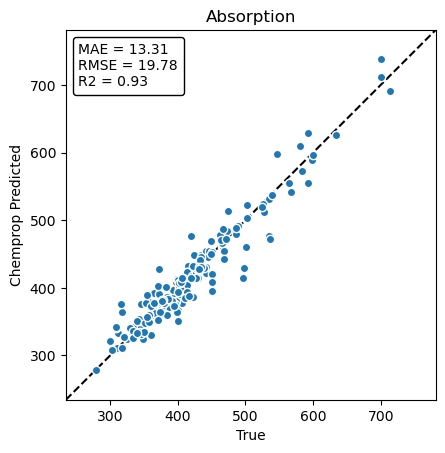

In [8]:
plot_parity(df_test["Absorption/nm"], df_test.absorption_preds, feature='Absorption')

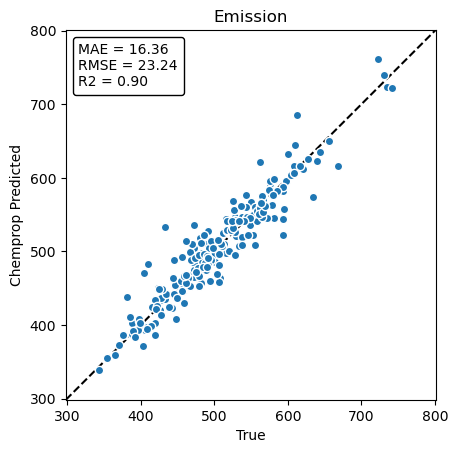

In [9]:
plot_parity(df_test['Emission/nm'], df_test.emission_preds, feature='Emission')

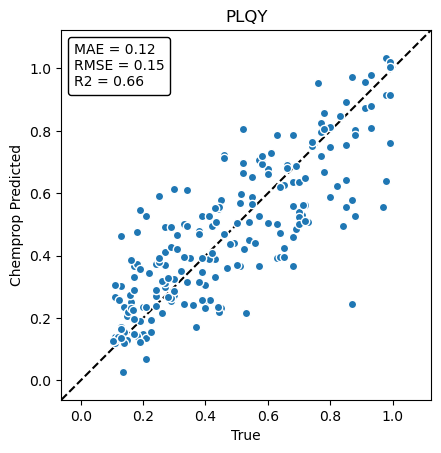

In [10]:
plot_parity(df_test['PLQY'], df_test.plqy_preds, feature='PLQY')